In [26]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
#from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
std=StandardScaler()

In [3]:
df_covid=pd.read_csv("covid_19_data.csv")
df_covid.head(10)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
5,6,01/22/2020,Guangdong,Mainland China,1/22/2020 17:00,26.0,0.0,0.0
6,7,01/22/2020,Guangxi,Mainland China,1/22/2020 17:00,2.0,0.0,0.0
7,8,01/22/2020,Guizhou,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
8,9,01/22/2020,Hainan,Mainland China,1/22/2020 17:00,4.0,0.0,0.0
9,10,01/22/2020,Hebei,Mainland China,1/22/2020 17:00,1.0,0.0,0.0


In [4]:
print(df_covid.shape)
print(df_covid.isnull().sum())
print("\n",df_covid.dtypes)

(18008, 8)
SNo                   0
ObservationDate       0
Province/State     9096
Country/Region        0
Last Update           0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64

 SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object


In [5]:
#Dropping column as SNo is of no use, and "Province/State" contains too many missing values
df_covid.drop(["SNo"],1,inplace=True)
df_covid.drop(["Province/State"],1,inplace=True)

In [6]:
df_covid

,ObservationDate,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,01/22/2020,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,01/22/2020,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,01/22/2020,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,01/22/2020,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,01/22/2020,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...
18003,04/23/2020,US,2020-04-24 03:31:35,453.0,7.0,0.0
18004,04/23/2020,Mainland China,2020-04-24 03:31:35,76.0,3.0,73.0
18005,04/23/2020,Canada,2020-04-24 03:31:35,11.0,0.0,0.0
18006,04/23/2020,Mainland China,2020-04-24 03:31:35,184.0,2.0,180.0


In [7]:
#Converting "Observation Date" into Datetime format
df_covid["ObservationDate"]=pd.to_datetime(df_covid["ObservationDate"])

In [8]:
#Grouping different types of cases as per the date
bydate=df_covid.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
bydate["Days Since"]=bydate.index-bydate.index.min()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92]),
 <a list of 93 Text xticklabel objects>)

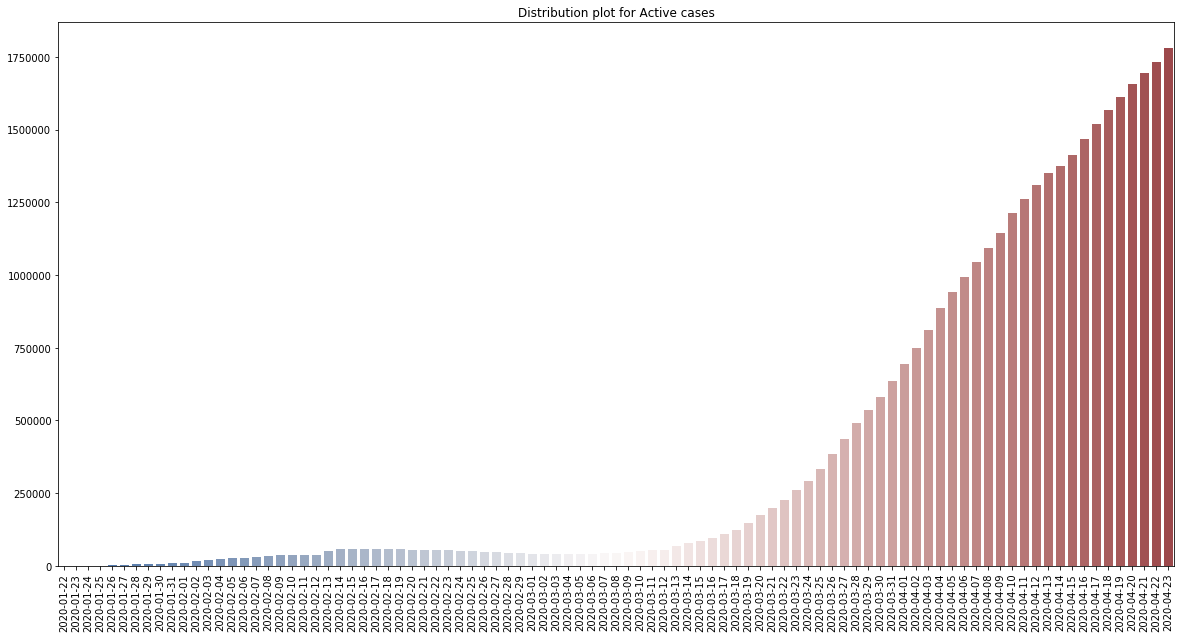

In [9]:
#plotting the distribution plot of active cases.
plt.figure(figsize=(20,10))
sns.barplot(x=bydate.index.date, y=bydate["Confirmed"]-bydate["Recovered"]-bydate["Deaths"],palette="vlag")
plt.title("Distribution plot for Active cases")
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92]),
 <a list of 93 Text xticklabel objects>)

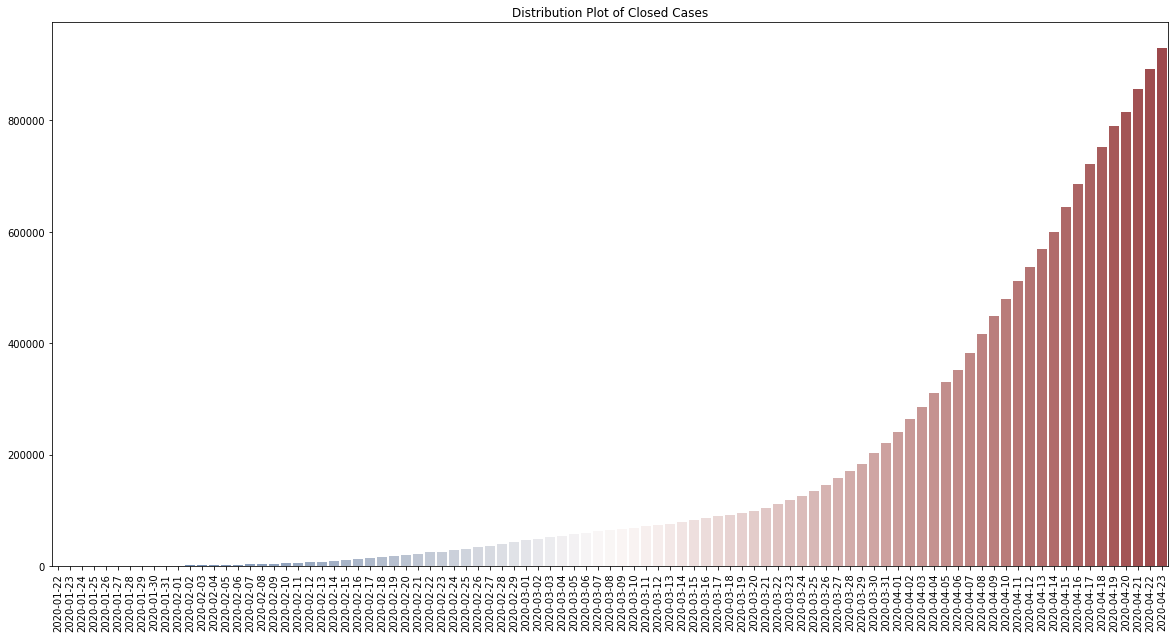

In [10]:
#plotting the distribution plot of cases over date
plt.figure(figsize=(20,10))
sns.barplot(x=bydate.index.date, y=bydate["Recovered"]+bydate["Deaths"], palette="vlag")
plt.title("Distribution Plot of Closed Cases")
plt.xticks(rotation=90)

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, **kwargs)>

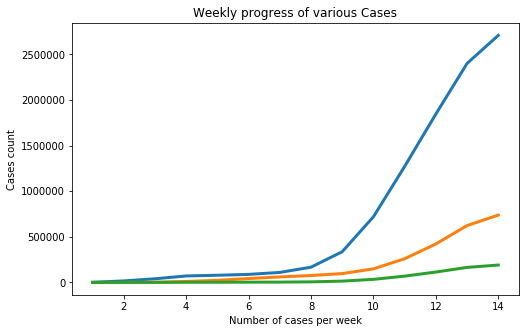

In [12]:
#weekly progress plotted 
bydate["WeekOfYear"]=bydate.index.weekofyear
#initializing empty lists
weekly_count=[]
confirm_week=[]
recover_week=[]
death_week=[]
w=1
for i in list(bydate["WeekOfYear"].unique()):
    confirm_week.append(bydate[bydate["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    recover_week.append(bydate[bydate["WeekOfYear"]==i]["Recovered"].iloc[-1])
    death_week.append(bydate[bydate["WeekOfYear"]==i]["Deaths"].iloc[-1])
    weekly_count.append(w)
    w=w+1

plt.figure(figsize=(8,5))
plt.plot(weekly_count,confirm_week,linewidth=3)
plt.plot(weekly_count,recover_week,linewidth=3)
plt.plot(weekly_count,death_week,linewidth=3)
plt.ylabel("Cases count")
plt.xlabel("Number of cases per week")
plt.title("Weekly progress of various Cases")
plt.xlabel

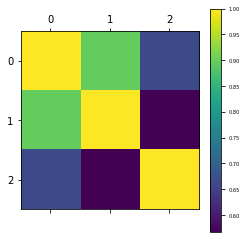

In [14]:
plt.matshow(df_covid.corr())
cb = plt.colorbar()
cb.ax.tick_params(labelsize=5)
plt.show()


In [15]:
#Intializing SVR Model
svm=SVR(C=1,degree=5,kernel='poly',epsilon=0.001)

In [16]:
bydate["Days Since"]=bydate.index-bydate.index[0]
bydate["Days Since"]=bydate["Days Since"].dt.days

In [17]:
train_ml=bydate.iloc[:int(bydate.shape[0]*0.95)]
valid_ml=bydate.iloc[int(bydate.shape[0]*0.95):]
model_scores=[]

In [18]:
#Fitting model on the training data
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

SVR(C=1, cache_size=200, coef0=0.0, degree=5, epsilon=0.001, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [19]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [20]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))

Root Mean Square Error for Support Vectore Machine:  219832.01666711172


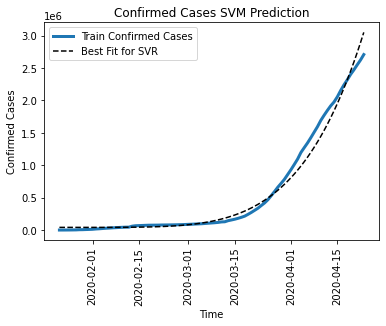

In [63]:
prediction_svm=svm.predict(np.array(bydate["Days Since"]).reshape(-1,1))
plt.plot(bydate["Confirmed"],label="Train Confirmed Cases",linewidth=3)
plt.plot(bydate.index,prediction_svm, linestyle='--',label="Best Fit for SVR",color='black')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases SVM Prediction")
plt.xticks(rotation=90)
plt.legend()

CLustering of Countries

In [22]:
#Calculating countrywise Moratality and Recovery Rate
countrywise=df_covid[df_covid["ObservationDate"]==df_covid["ObservationDate"].max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)
countrywise["Mortality"]=(countrywise["Deaths"]/countrywise["Confirmed"])*100
countrywise["Recovery"]=(countrywise["Recovered"]/countrywise["Confirmed"])*100

In [23]:
X=countrywise[["Confirmed","Recovered","Deaths"]]
X=std.fit_transform(X)

In [24]:
wcss=[]
sil=[]
for i in range(2,11):
    clf=KMeans(n_clusters=i,init='k-means++',random_state=42)
    clf.fit(X)
    labels=clf.labels_
    centroids=clf.cluster_centers_
    sil.append(silhouette_score(X, labels, metric='euclidean'))
    wcss.append(clf.inertia_)

In [25]:
clf_final=KMeans(n_clusters=4,init='k-means++',random_state=42)
clf_final.fit(X)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [26]:
clf_pred=clf_final.predict(X)

In [27]:
countrywise["Clusters"]=clf_final.predict(X)

Liner Regression

In [28]:
bydate["Days Since"]=bydate.index-bydate.index[0]
bydate["Days Since"]=bydate["Days Since"].dt.days

In [29]:
train_ml=bydate.iloc[:int(bydate.shape[0]*0.95)]
valid_ml=bydate.iloc[int(bydate.shape[0]*0.95):]
model_scores=[]

In [30]:
lin_reg=LinearRegression(normalize=True)

In [31]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [32]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [33]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  1126459.1341621012


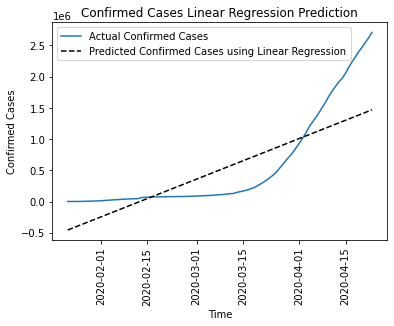

In [34]:
prediction_linreg=lin_reg.predict(np.array(bydate["Days Since"]).reshape(-1,1))
plt.plot(bydate["Confirmed"],label="Actual Confirmed Cases")
plt.plot(bydate.index,prediction_linreg, linestyle='--',label="Predicted Confirmed Cases using Linear Regression",color='black')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Linear Regression Prediction")
plt.xticks(rotation=90)
plt.legend()

In [35]:
new_date=[]
new_prediction_lr=[]
new_prediction_svm=[]
for i in range(1,18):
    new_date.append(bydate.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(bydate["Days Since"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svm.append(svm.predict(np.array(bydate["Days Since"].max()+i).reshape(-1,1))[0])

In [36]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_svm),columns=["Dates","Linear Regression Prediction","SVM Prediction"])
model_predictions.head()

,Dates,Linear Regression Prediction,SVM Prediction
0,2020-04-24,1490136.613267,3218615.477537
1,2020-04-25,1511065.843287,3393133.975194
2,2020-04-26,1531995.073307,3575238.917801
3,2020-04-27,1552924.303327,3765175.001545
4,2020-04-28,1573853.533347,3963192.128627


Kmeans clustering

In [56]:
#Calculating countrywise Moratality and Recovery Rate
countrywise=df_covid[df_covid["ObservationDate"]==df_covid["ObservationDate"].max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)
countrywise["Mortality"]=(countrywise["Deaths"]/countrywise["Confirmed"])*100
countrywise["Recovery"]=(countrywise["Recovered"]/countrywise["Confirmed"])*100

In [57]:
X=countrywise[["Confirmed","Recovered","Deaths"]]
X=std.fit_transform(X)

In [58]:
myL=[]
myL1=[]
for i in range(2,11):
    clf=KMeans(n_clusters=i,init='k-means++',random_state=42)
    clf.fit(X)
    labels=clf.labels_
    centroids=clf.cluster_centers_
    myL1.append(silhouette_score(X, labels, metric='euclidean'))
    myL.append(clf.inertia_)

Text(0.5, 0, 'Number of Clusters')

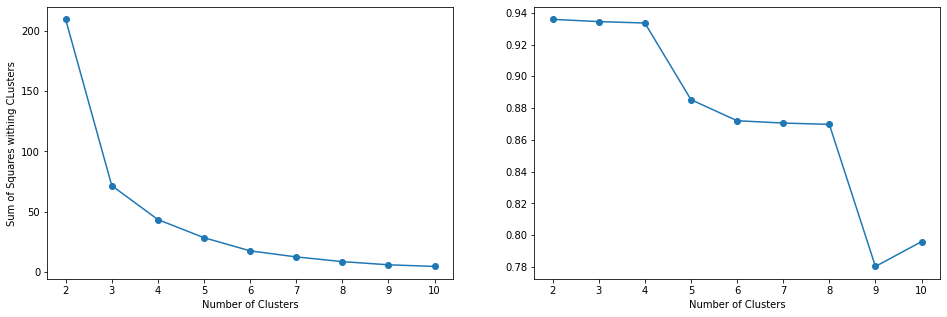

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,5))
x=np.arange(2,11)
ax1.plot(x,myL,marker='o')
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Sum of Squares withing CLusters")
x=np.arange(2,11)
ax2.plot(x,myL1,marker='o')
ax2.set_xlabel("Number of Clusters")


In [66]:
clf_final=KMeans(n_clusters=4,init='k-means++',random_state=42)
clf_final.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [67]:
countrywise["Clusters"]=clf_final.predict(X)

In [68]:
#Summary of Clusters

In [69]:
pd.concat([countrywise[countrywise["Clusters"]==1],countrywise[countrywise["Clusters"]==2],countrywise[countrywise["Clusters"]==3],countrywise[countrywise["Clusters"]==0].head(15)])

,Confirmed,Recovered,Deaths,Mortality,Recovery,Clusters
Country/Region,,,,,,
Spain,213024.000000,89250.000000,22157.000000,10.401175,41.896688,1
Italy,189973.000000,57576.000000,25549.000000,13.448753,30.307465,1
France,159460.000000,42762.000000,21889.000000,13.726953,26.816757,1
UK,139246.000000,712.000000,18791.000000,13.494822,0.511325,1
US,869170.000000,80203.000000,49954.000000,5.747322,9.227539,2
Germany,153129.000000,103300.000000,5575.000000,3.640721,67.459462,3
Iran,87026.000000,64843.000000,5481.000000,6.298118,74.509917,3
Mainland China,82804.000000,77257.000000,4632.000000,5.593933,93.301048,3
Turkey,101790.000000,18491.000000,2491.000000,2.447195,18.165832,0


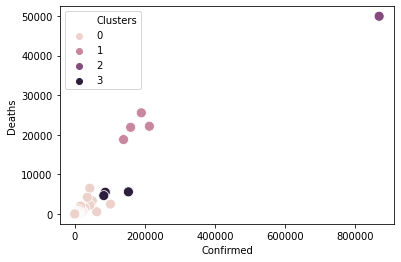

In [71]:
sns.scatterplot(x=countrywise["Confirmed"],y=countrywise["Deaths"],hue=countrywise["Clusters"],s=100)

Holts Winter Forecasting Model

In [72]:
model_train=bydate.iloc[:int(bydate.shape[0]*0.95)]
valid=bydate.iloc[int(bydate.shape[0]*0.95):]
y_pred=valid.copy()

In [73]:
holts=Holt(np.asarray(model_train["Confirmed"])).fit(smoothing_level=0.9, smoothing_slope=0.1)
y_pred=valid.copy()

In [74]:
y_pred["Holt"]=holts.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  8425.517798000774


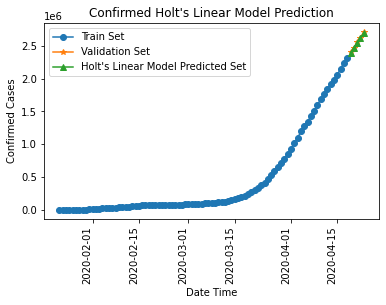

In [75]:
plt.plot(model_train.Confirmed,label="Train Set",marker='o')
valid.Confirmed.plot(label="Validation Set",marker='*')
y_pred.Holt.plot(label="Holt's Linear Model Predicted Set",marker='^')
plt.ylabel("Confirmed Cases")
plt.xlabel("Date Time")
plt.title("Confirmed Holt's Linear Model Prediction")
plt.xticks(rotation=90)
plt.legend()

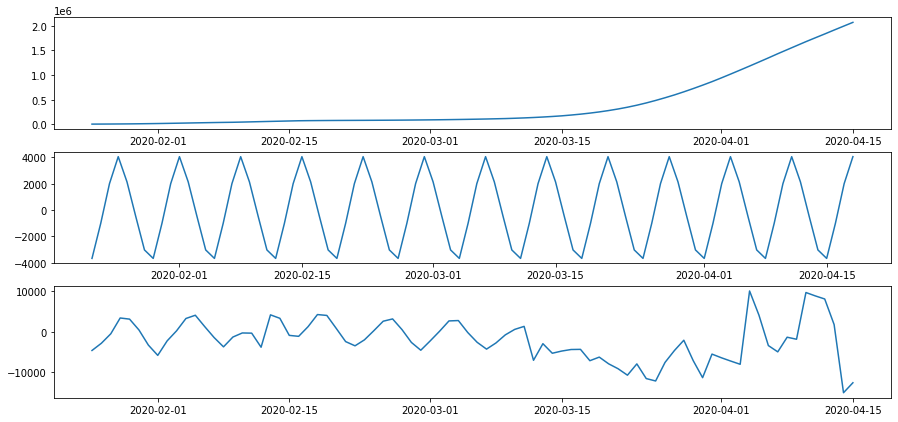

In [76]:
fig, (ax1,ax2,ax3) = plt.subplots(3, 1,figsize=(15,7))
import statsmodels.api as sm
results=sm.tsa.seasonal_decompose(model_train["Confirmed"])
ax1.plot(results.trend)
ax2.plot(results.seasonal)
ax3.plot(results.resid)

In [14]:
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')
linear=LinearRegression()
logistic=LogisticRegression()
tree=DecisionTreeRegressor()

In [24]:
    df_covid['ObservationDate']=df_covid['ObservationDate'].astype('datetime64[ns]')

In [22]:
from sklearn.model_selection import train_test_split
x=df_covid[['Deaths','Recovered']]
y=df_covid['Confirmed']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [23]:
linear.fit(x_train,y_train)
logistic.fit(x_train,y_train)
tree.fit(x_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [27]:
req=comp_data[["Confirmed","Deaths","Recovered"]
plt.figure(figsize=(10,5))
mask = np.triu(np.ones_like(req.corr(), dtype=np.bool))
sns.heatmap(req.corr(),annot=True, mask=mask)

SyntaxError: invalid syntax (<ipython-input-27-1e0b5ed66de4>, line 2)

,Confirmed,Deaths,Recovered
Confirmed,1.000000,0.898481,0.664646
Deaths,0.898481,1.000000,0.567548
Recovered,0.664646,0.567548,1.000000


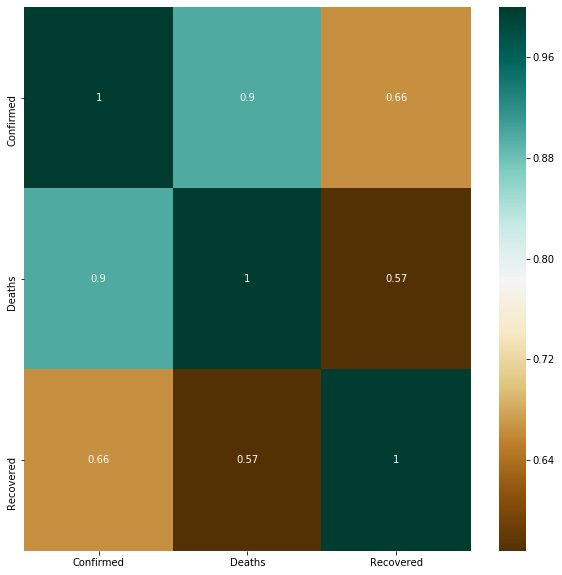

In [30]:
# Finding the relations between the variables.
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
c= df_covid.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

In [31]:
# import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

In [33]:
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(df_covid, method='ward'))
# create clusters
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_hc = hc.fit_predict(df)

TypeError: float() argument must be a string or a number, not 'Timestamp'